# CalibratedClassifier  CV
# Probability calibration with isotonic regression or sigmoid

CalibratedClassifierCV(base_estimator=None, method='sigmoid', cv='warn')

* <font color=red>base_estimator</font>: instance BaseEstimator  
需要对其输出决策函数进行校准的分类器为了提供更准确的predict_proba输出。如果cv=prefit,分类器必须已经适合于数据。<br><br>
* <font color=red>method</font>: 'sigmoid' or 'isotonic'  
用于校准的方法. 可能是符合普拉特方法的'sigmoid'或者是'isotonic'的非参数方法。不建议使用同位素标定，标定样品太少(<1000)，因为它容易过拟合。在这种情况下使用sigmoids (Platt的校准)。
* <font color=red>cv</font>: integer, cross-validation generator, iterable or "prefit", optional  
    确定交叉验证拆分策略，cv的输入可能是：
    - None,要使用默认的3-fold交叉验证
    - integer,指定折叠的次数。
    - 要用作交叉验证生成器的对象。
    - An iterable yielding train/test splits.可迭代产生的 train/test分割。<br><br> 
    对于输入是 integer/None
    - 如果二进制或者多类使用sklearn.model_selection.StratifiedKFold
    - 如果输入既非二进制也非多类使用sklearn.model_selection.KFold<br><br>  
    Refer:参考 ref:User Guide <cross_validation>可以使用交叉验证策略。 <br><br> 
    如果'prefit'被忽略,假设base_estimator已经被拟合，所有数据都用于校准。

In [2]:
import warnings
warnings.filterwarnings("ignore")

Automatically created module for IPython interactive environment
Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

Naive Bayes:
	Brier: 0.118
	Precision: 0.857
	Recall: 0.876
	F1: 0.867

Naive Bayes + Isotonic:
	Brier: 0.098
	Precision: 0.883
	Recall: 0.836
	F1: 0.859

Naive Bayes + Sigmoid:
	Brier: 0.109
	Precision: 0.861
	Recall: 0.871
	F1: 0.866

Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

SVC:
	Brier: 0.163
	Precision: 0.872
	Recall: 0.852
	F1: 0.862

SVC + Isotonic:
	Brier: 0.100
	Precision: 0.853
	Recall: 0.878
	F1: 0.865

SVC + Sigmoid:
	Brier: 0.099
	Precision: 0.874
	Recall: 0.849
	F1: 0.861



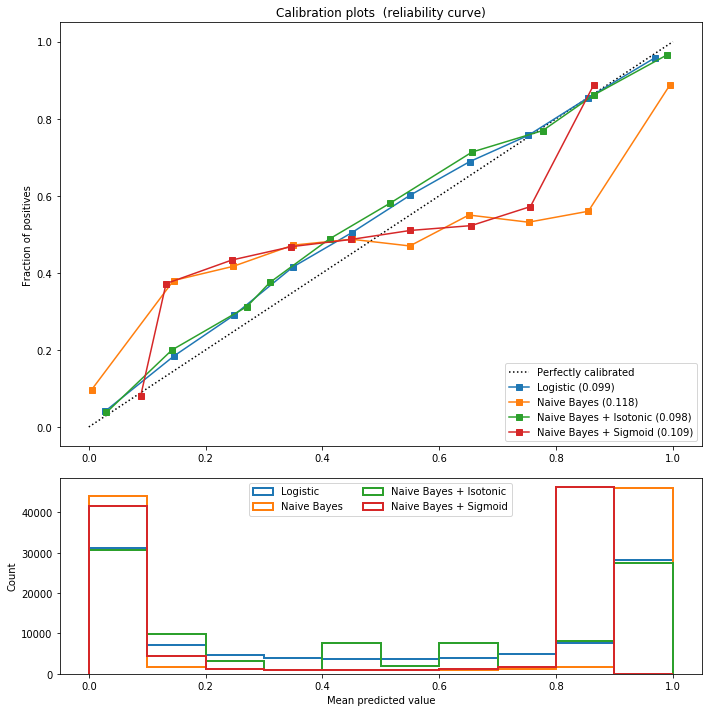

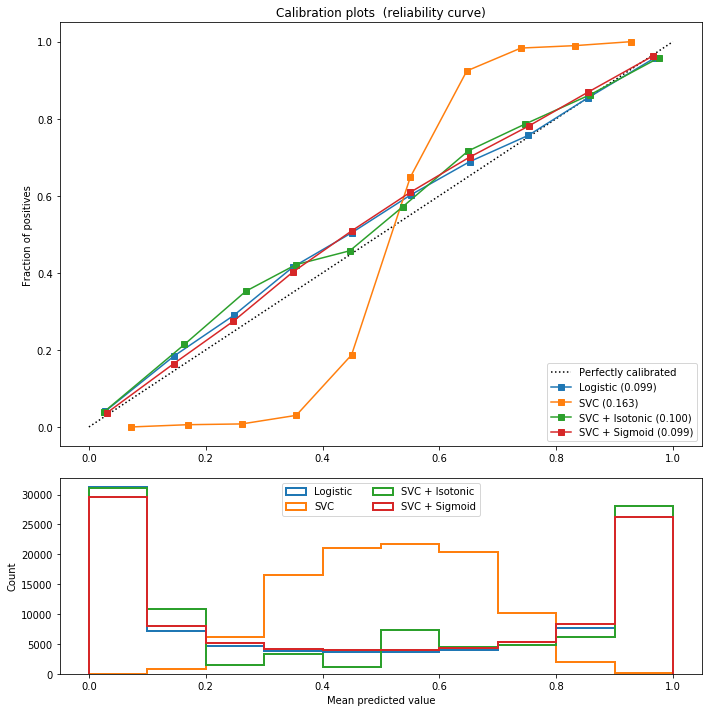

In [3]:
print(__doc__)

# Author: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split


#构建一份数据，具体参数参照Datasets
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)
#划分train，test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)


def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(), "SVC", 2)

plt.show()

Automatically created module for IPython interactive environment
Brier scores: (the smaller the better)
No calibration: 0.104
With isotonic calibration: 0.084
With sigmoid calibration: 0.109


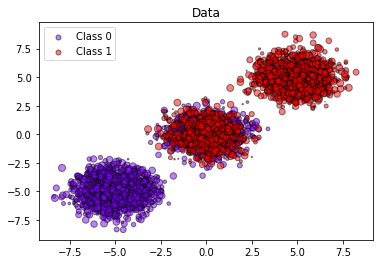

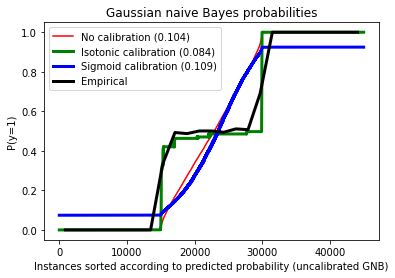

In [4]:
print(__doc__)

# Author: Mathieu Blondel <mathieu@mblondel.org>
#         Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Balazs Kegl <balazs.kegl@gmail.com>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_blobs
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split


n_samples = 50000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.0,
                  centers=centers, shuffle=False, random_state=42)

y[:n_samples // 2] = 0
y[n_samples // 2:] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])

# split train, test for calibration
X_train, X_test, y_train, y_test, sw_train, sw_test = \
    train_test_split(X, y, sample_weight, test_size=0.9, random_state=42)

# Gaussian Naive-Bayes with no calibration
clf = GaussianNB()
clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
clf_isotonic.fit(X_train, y_train, sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method='sigmoid')
clf_sigmoid.fit(X_train, y_train, sw_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

print("Brier scores: (the smaller the better)")

clf_score = brier_score_loss(y_test, prob_pos_clf, sw_test)
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, sw_test)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid, sw_test)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

# #############################################################################
# Plot the data and the predicted probabilities
plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50, c=color,
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")

plt.figure()
order = np.lexsort((prob_pos_clf, ))
plt.plot(prob_pos_clf[order], 'r', label='No calibration (%1.3f)' % clf_score)
plt.plot(prob_pos_isotonic[order], 'g', linewidth=3,
         label='Isotonic calibration (%1.3f)' % clf_isotonic_score)
plt.plot(prob_pos_sigmoid[order], 'b', linewidth=3,
         label='Sigmoid calibration (%1.3f)' % clf_sigmoid_score)
plt.plot(np.linspace(0, y_test.size, 51)[1::2],
         y_test[order].reshape(25, -1).mean(1),
         'k', linewidth=3, label=r'Empirical')
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability "
           "(uncalibrated GNB)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Gaussian naive Bayes probabilities")

plt.show()

Automatically created module for IPython interactive environment
Log-loss of
 * uncalibrated classifier trained on 800 datapoints: 1.280 
 * classifier trained on 600 datapoints and calibrated on 200 datapoint: 0.534


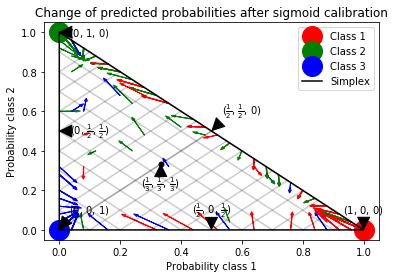

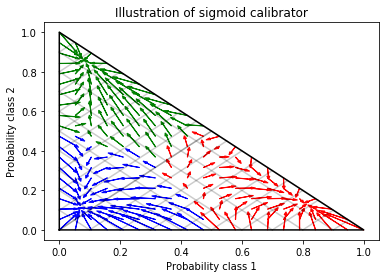

In [5]:
print(__doc__)

# Author: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.


import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

np.random.seed(0)

# Generate data
X, y = make_blobs(n_samples=1000, n_features=2, random_state=42,
                  cluster_std=5.0)
X_train, y_train = X[:600], y[:600]
X_valid, y_valid = X[600:800], y[600:800]
X_train_valid, y_train_valid = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]

# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train_valid, y_train_valid)
clf_probs = clf.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

# Train random forest classifier, calibrate on validation data and evaluate
# on test data
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)
clf_probs = clf.predict_proba(X_test)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(X_valid, y_valid)
sig_clf_probs = sig_clf.predict_proba(X_test)
sig_score = log_loss(y_test, sig_clf_probs)

# Plot changes in predicted probabilities via arrows
plt.figure(0)
colors = ["r", "g", "b"]
for i in range(clf_probs.shape[0]):
    plt.arrow(clf_probs[i, 0], clf_probs[i, 1],
              sig_clf_probs[i, 0] - clf_probs[i, 0],
              sig_clf_probs[i, 1] - clf_probs[i, 1],
              color=colors[y_test[i]], head_width=1e-2)

# Plot perfect predictions
plt.plot([1.0], [0.0], 'ro', ms=20, label="Class 1")
plt.plot([0.0], [1.0], 'go', ms=20, label="Class 2")
plt.plot([0.0], [0.0], 'bo', ms=20, label="Class 3")

# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], 'k', label="Simplex")

# Annotate points on the simplex
plt.annotate(r'($\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$)',
             xy=(1.0/3, 1.0/3), xytext=(1.0/3, .23), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.plot([1.0/3], [1.0/3], 'ko', ms=5)
plt.annotate(r'($\frac{1}{2}$, $0$, $\frac{1}{2}$)',
             xy=(.5, .0), xytext=(.5, .1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($0$, $\frac{1}{2}$, $\frac{1}{2}$)',
             xy=(.0, .5), xytext=(.1, .5), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($\frac{1}{2}$, $\frac{1}{2}$, $0$)',
             xy=(.5, .5), xytext=(.6, .6), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($0$, $0$, $1$)',
             xy=(0, 0), xytext=(.1, .1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($1$, $0$, $0$)',
             xy=(1, 0), xytext=(1, .1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($0$, $1$, $0$)',
             xy=(0, 1), xytext=(.1, 1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
# Add grid
plt.grid("off")
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], 'k', alpha=0.2)
    plt.plot([0, 0 + (1-x)/2], [x, x + (1-x)/2], 'k', alpha=0.2)
    plt.plot([x, x + (1-x)/2], [0, 0 + (1-x)/2], 'k', alpha=0.2)

plt.title("Change of predicted probabilities after sigmoid calibration")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.legend(loc="best")

print("Log-loss of")
print(" * uncalibrated classifier trained on 800 datapoints: %.3f "
      % score)
print(" * classifier trained on 600 datapoints and calibrated on "
      "200 datapoint: %.3f" % sig_score)

# Illustrate calibrator
plt.figure(1)
# generate grid over 2-simplex
p1d = np.linspace(0, 1, 20)
p0, p1 = np.meshgrid(p1d, p1d)
p2 = 1 - p0 - p1
p = np.c_[p0.ravel(), p1.ravel(), p2.ravel()]
p = p[p[:, 2] >= 0]

calibrated_classifier = sig_clf.calibrated_classifiers_[0]
prediction = np.vstack([calibrator.predict(this_p)
                        for calibrator, this_p in
                        zip(calibrated_classifier.calibrators_, p.T)]).T
prediction /= prediction.sum(axis=1)[:, None]

# Plot modifications of calibrator
for i in range(prediction.shape[0]):
    plt.arrow(p[i, 0], p[i, 1],
              prediction[i, 0] - p[i, 0], prediction[i, 1] - p[i, 1],
              head_width=1e-2, color=colors[np.argmax(p[i])])
# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], 'k', label="Simplex")

plt.grid("off")
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], 'k', alpha=0.2)
    plt.plot([0, 0 + (1-x)/2], [x, x + (1-x)/2], 'k', alpha=0.2)
    plt.plot([x, x + (1-x)/2], [0, 0 + (1-x)/2], 'k', alpha=0.2)

plt.title("Illustration of sigmoid calibrator")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plt.show()